In [1]:
%load_ext autoreload
%autoreload 2

import numpy  as np
import pandas as pd
import h5py

from matplotlib import pyplot as plt, cm
from astropy    import units  as u
from tqdm       import tqdm

from common import hallmark as hm
from common import viz

In [2]:
pf = hm.ParaFrame('cache/Illinois_thermal_w{win:d}/{mag}a{aspin:g}_i{inc:d}/sed_Rh{Rhigh:d}.h5')

for k in set(pf.keys()) - {'path'}:
    globals()[k] = np.unique(pf[k])
    print(k, globals()[k][:16])

win [3 4 5]
Rhigh [  1  10  40 160]
mag ['M' 'S']
aspin [-0.94 -0.5   0.    0.5   0.94]
inc [ 10  30  50  70  90 110 130 150 170]


In [3]:
colors = ['red', 'darkorange', 'darkgreen', 'darkblue', 'purple']
colors = colors[:0:-1] + colors
styles = ['-'] * 5 + [':'] * 4

magmap = {'M':'MAD', 'S':'SANE'}

def Fnu_to_nuLnu(nu, Fnu):
    d = 8.127e3 * u.pc
    S = 4 * np.pi * d * d
    return (Fnu*u.Jy * S * nu*u.Hz).to(u.erg/u.second).value

def readsed(f, snapshot=None):
    with h5py.File(f) as h:
        time = h['time'][:]
        nu   = h['nu'  ][:]
        knd  = h['knd' ][:]
        avg  = h['avg' ][:]
      # err  = h['err' ][:]
        rlz  = h['len' ][:]

    if not all(rlz == 16):
        print('WARNING: less than 16 realizations:', f)
        
    if snapshot is None:
        m = np.mean(avg, axis=0)
        s = np.std (avg, axis=0)
    else:
        m = avg[snapshot,...]
        s = 0
        
    return nu, m, s, [k.decode("utf-8") for k in knd]

def plot_multiscat(ax, pf, snapshot=None):
    for i, p in enumerate(pf.path):
        nu, avg, err, knd = readsed(p, snapshot=snapshot)
        viz.step(ax, nu, avg, label=knd)
    ax.set_xlim(1e9,  1e23)
    ax.set_ylim(1e27, 1e37)
    ax.errorbar(
        [86e9, 230e9, 1.4141e+14, 1.45e18], 
        [Fnu_to_nuLnu(86e9,1.9), Fnu_to_nuLnu(230e9,2.4), Fnu_to_nuLnu(1.4141e+14,1e-3), 1e33],
        yerr=[Fnu_to_nuLnu(86e9,0.2), 0, Fnu_to_nuLnu(1.4141e+14,1e-3)/2, 1e33/2],
        uplims=[False,False,True,True],
        fmt='o', color='k'
    )
    
def plot_multiinc(ax, pf):
    for i, (_, r) in enumerate(pf.iterrows()):
        nu, avg, err, knd = readsed(r.path)
        viz.step(ax, nu, avg[:,0], linestyle=styles[i], color=colors[i], alpha=0.5, step=False, label=[rf'$i={r.inc}^\circ$'])
    ax.set_xlim(1e9,  1e23)
    ax.set_ylim(1e27, 1e37)
    ax.errorbar(
        [86e9, 230e9, 1.4141e+14, 1.45e18], 
        [Fnu_to_nuLnu(86e9,1.9), Fnu_to_nuLnu(230e9,2.4), Fnu_to_nuLnu(1.4141e+14,1e-3), 1e33],
        yerr=[Fnu_to_nuLnu(86e9,0.2), 0, Fnu_to_nuLnu(1.4141e+14,1e-3)/2, 1e33/2],
        uplims=[False,False,True,True],
        fmt='o', color='k'
    )
    
def plot_multiwin(ax, pf):
    for i, (_, r) in enumerate(pf.iterrows()):
        nu, avg, err, knd = readsed(r.path)
        viz.step(ax, nu, avg[:,0], color=f'C{i}', step=False, label=[f'win {r.win}'])
    ax.set_xlim(1e9,  1e23)
    ax.set_ylim(1e27, 1e37)
    ax.errorbar(
        [86e9, 230e9, 1.4141e+14, 1.45e18], 
        [Fnu_to_nuLnu(86e9,1.9), Fnu_to_nuLnu(230e9,2.4), Fnu_to_nuLnu(1.4141e+14,1e-3), 1e33],
        yerr=[Fnu_to_nuLnu(86e9,0.2), 0, Fnu_to_nuLnu(1.4141e+14,1e-3)/2, 1e33/2],
        uplims=[False,False,True,True],
        fmt='o', color='k'
    )


In [4]:
w  = 5
i  = 50
a  = 0.5
Rh = 10

for m in mag:
    for s in tqdm(range(100)):
        t = (s*10+w*1000)*5
        
        def plot(*args, **kwargs):
            return plot_multiscat(*args, **kwargs, snapshot=s)
    
        fig = viz.grid(pf(win=w)(mag=m)(inc=i), plot, aspin=[a], Rhigh=[Rh],
                       figsize=(6,6), title=f'SED for {magmap[m]}, inclincation $i={i}^\circ$, time $t={t}M$',
                       xtitle=r'$a_\mathrm{{spin}}={}$', ytitle=r'$R_\mathrm{{high}}={}$',
                       xlabel=r'Frequency $\nu$ [Hz]',   ylabel=r'$\nu F_\nu$ [erg/s]',
                       legend='upper right',
                       fout=f'output/movie/sedsample_{magmap[m]}_{s:03d}.png')
        plt.close(fig)

100%|█████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:22<00:00,  1.22it/s]


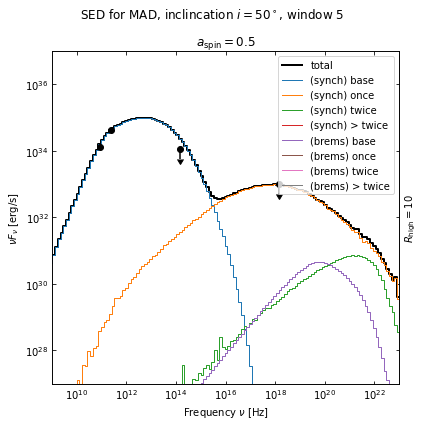

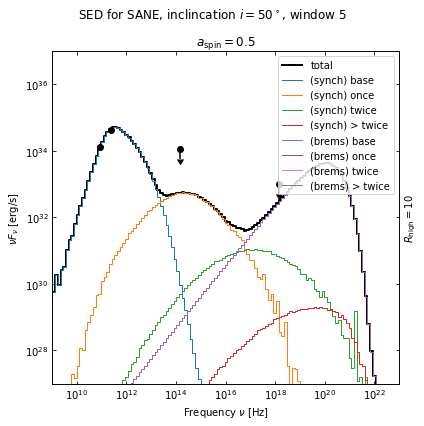

In [6]:
w  = 5
i  = 50
a  = 0.5
Rh = 10

for m in ['M', 'S']:
    fig = viz.grid(pf(win=w)(mag=m)(inc=i), plot_multiscat, aspin=[a], Rhigh=[Rh],
                   figsize=(6,6), title=f'SED for {magmap[m]}, inclincation $i={i}^\circ$, window {w}',
                   xtitle=r'$a_\mathrm{{spin}}={}$', ytitle=r'$R_\mathrm{{high}}={}$',
                   xlabel=r'Frequency $\nu$ [Hz]',   ylabel=r'$\nu F_\nu$ [erg/s]',
                   legend='upper right',
                   fout=f'output/plot/sedsample_{magmap[m]}')

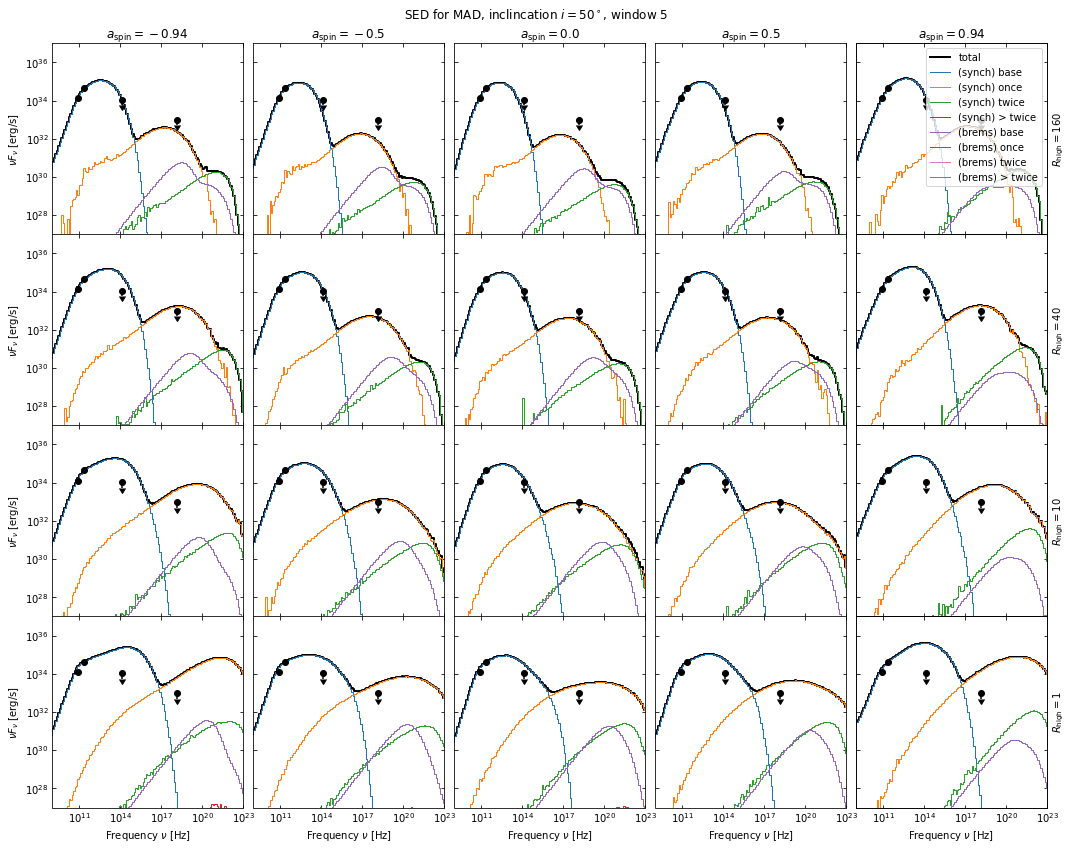

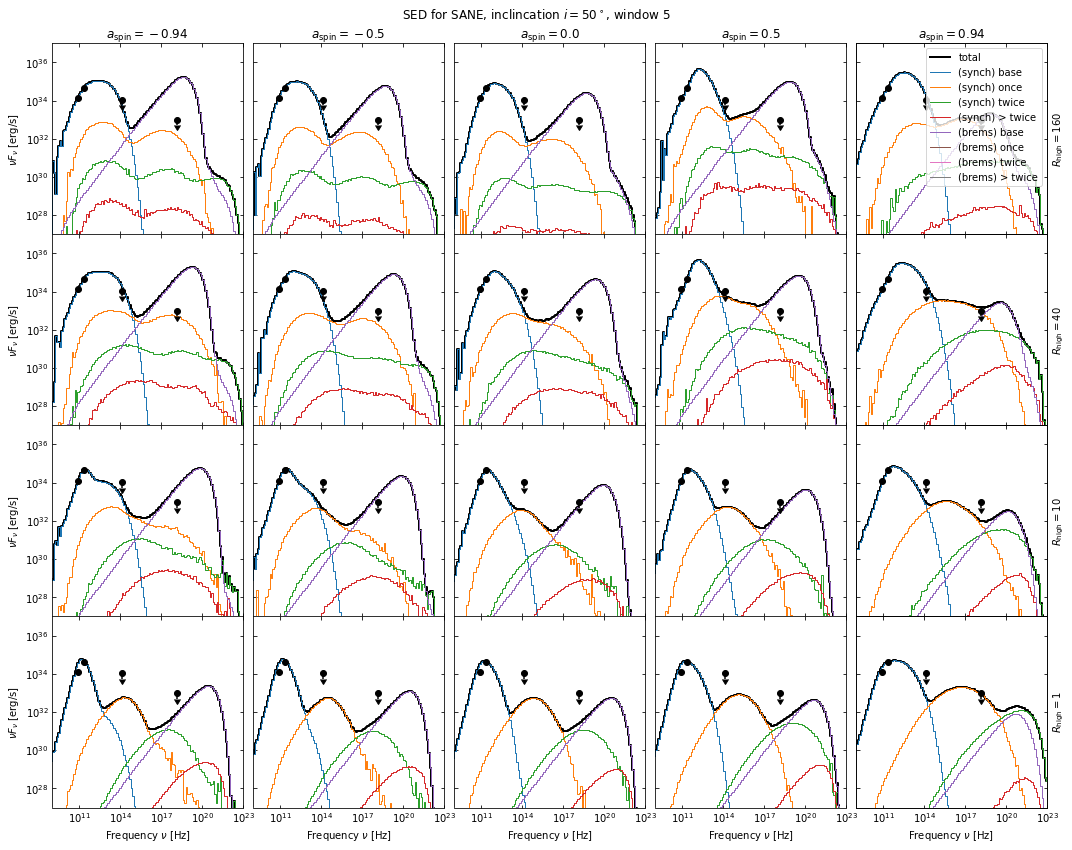

In [7]:
w = 5
i = 50

for m in mag:
    fig = viz.grid(pf(win=w)(mag=m)(inc=i), plot_multiscat, aspin=aspin, Rhigh=Rhigh[::-1],
                   figsize=(15,12), title=f'SED for {magmap[m]}, inclincation $i={i}^\circ$, window {w}',
                   xtitle=r'$a_\mathrm{{spin}}={}$', ytitle=r'$R_\mathrm{{high}}={}$',
                   xlabel=r'Frequency $\nu$ [Hz]',   ylabel=r'$\nu F_\nu$ [erg/s]',
                   legend='upper right',
                   fout=f'output/plot/sedscat_{magmap[m]}')

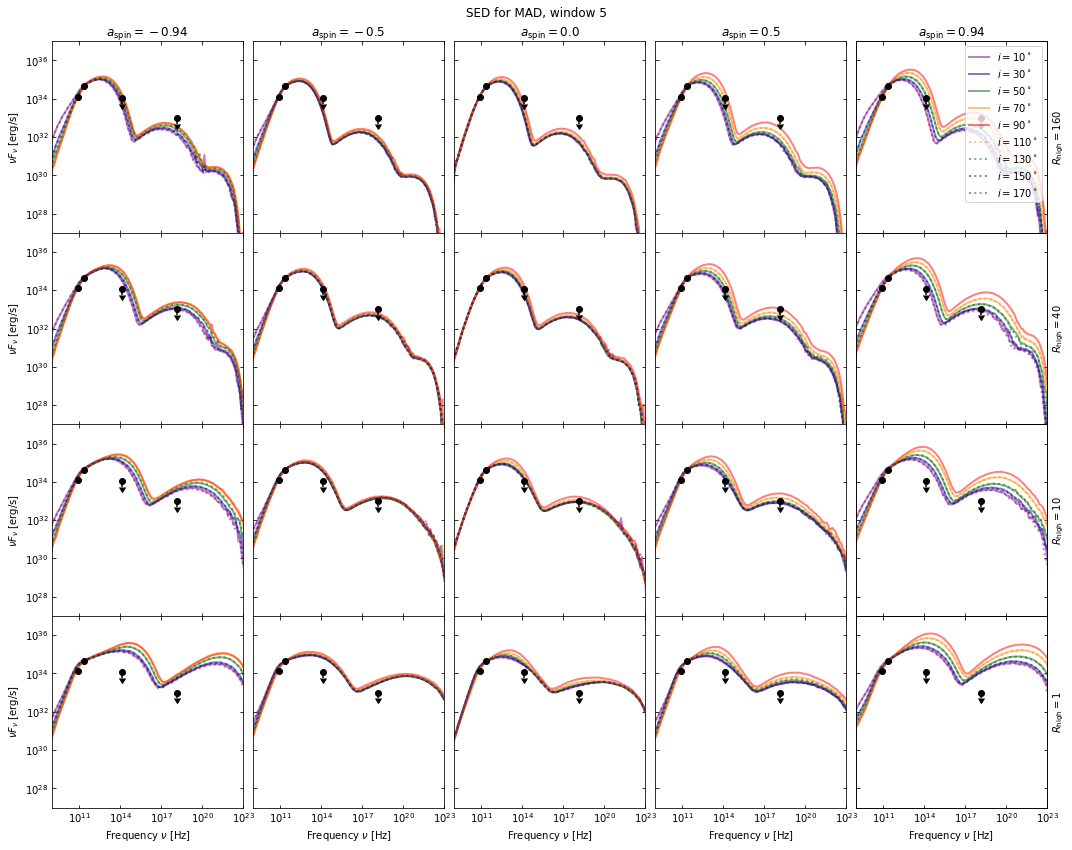

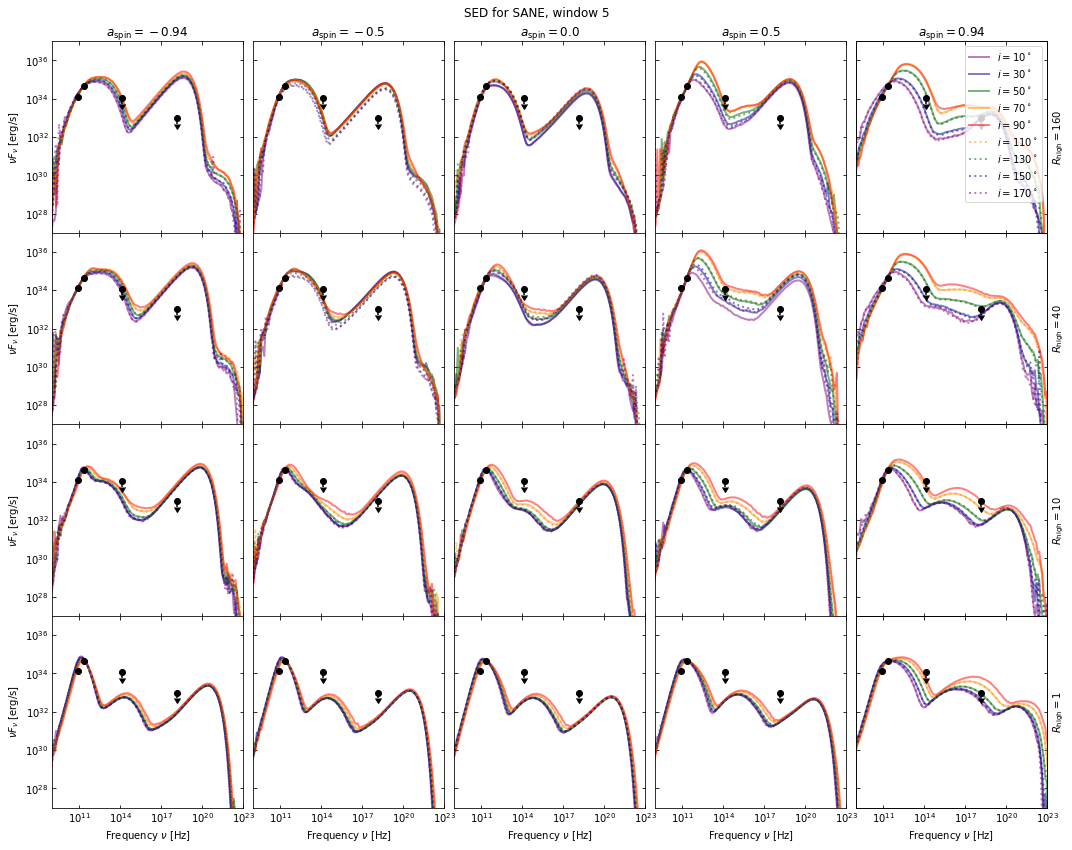

In [8]:
w = 5

for m in mag:
    viz.grid(pf(win=w)(mag=m).sort_values('inc'), plot_multiinc, aspin=aspin, Rhigh=Rhigh[::-1],
             figsize=(15,12), title=f'SED for {magmap[m]}, window {w}',
             xtitle=r'$a_\mathrm{{spin}}={}$', ytitle=r'$R_\mathrm{{high}}={}$',
             xlabel=r'Frequency $\nu$ [Hz]',  ylabel=r'$\nu F_\nu$ [erg/s]',
             legend='upper right',
             fout=f'output/plot/sedinc_{magmap[m]}')

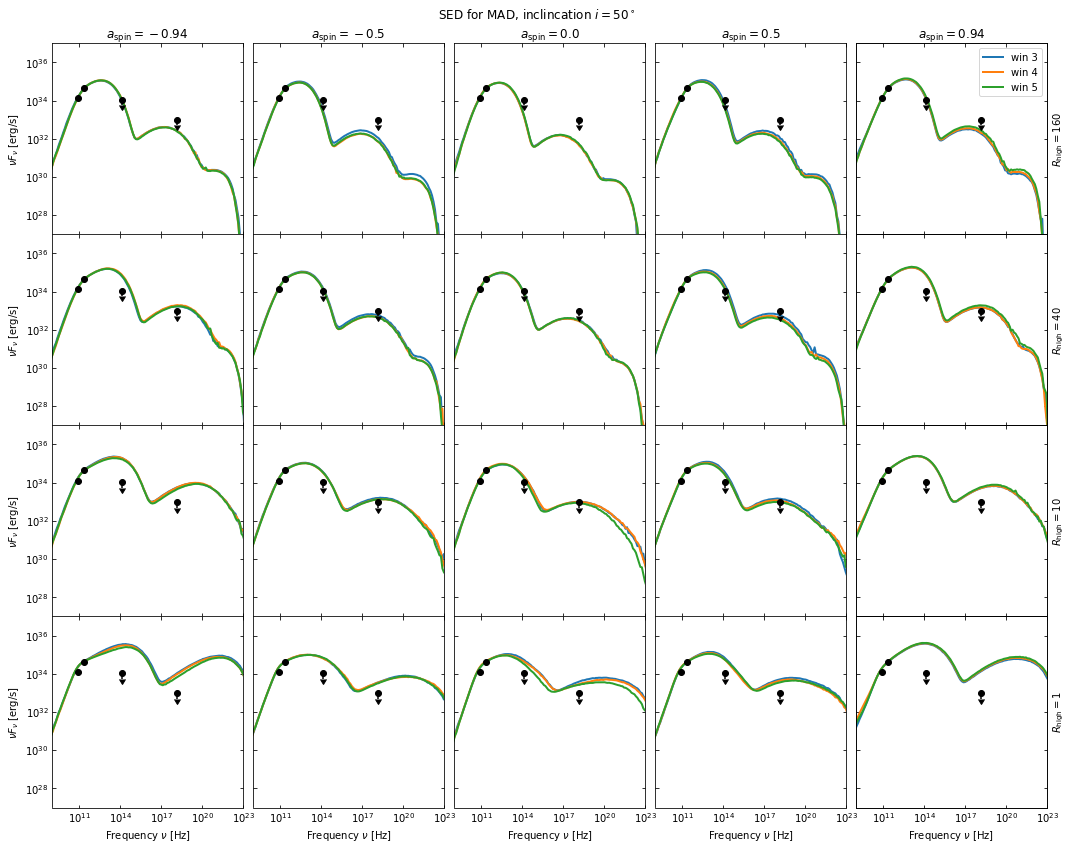

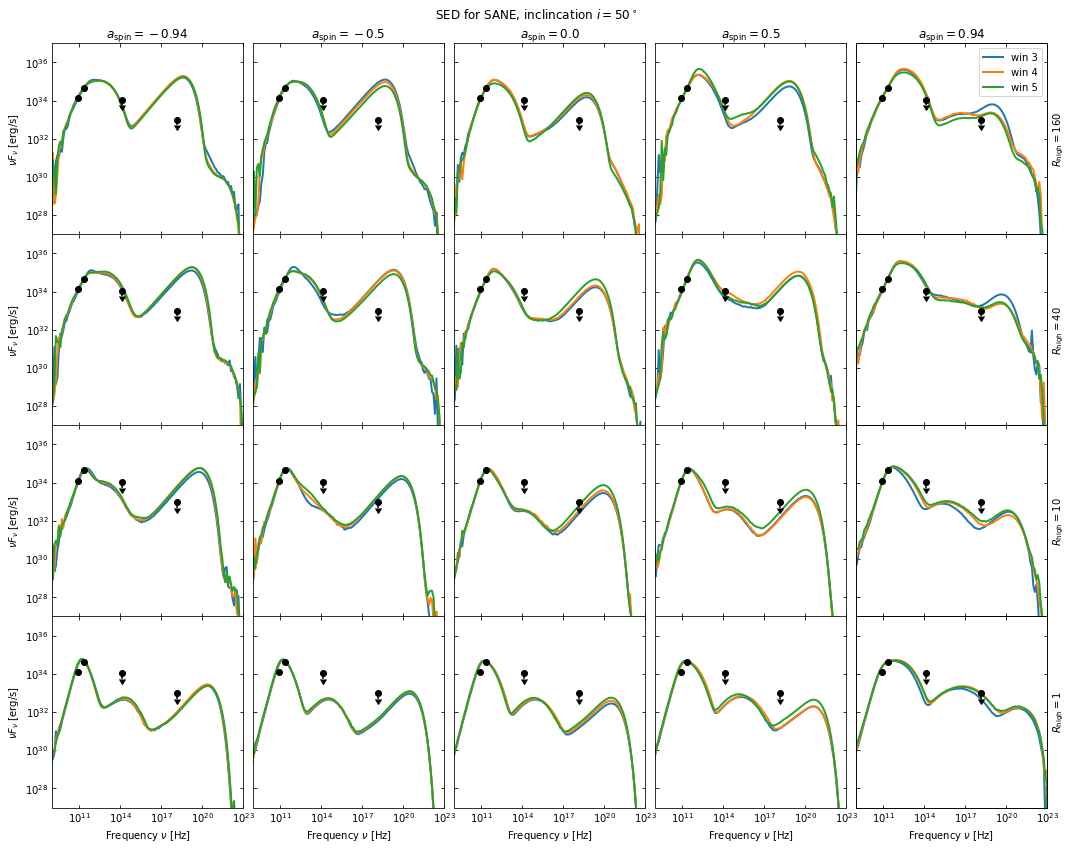

In [9]:
i = 50

for m in mag:
    viz.grid(pf(mag=m)(inc=i).sort_values('win'), plot_multiwin, aspin=aspin, Rhigh=Rhigh[::-1],
             figsize=(15,12), title=f'SED for {magmap[m]}, inclincation $i={i}^\circ$',
             xtitle=r'$a_\mathrm{{spin}}={}$', ytitle=r'$R_\mathrm{{high}}={}$',
             xlabel=r'Frequency $\nu$ [Hz]',  ylabel=r'$\nu F_\nu$ [erg/s]',
             legend='upper right',
             fout=f'output/plot/sedwin_{magmap[m]}')